In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

###########################################
# Helper: Recursive SHAP-Based Feature Ranking
###########################################
def recursive_shap_feature_ranking(X, y, model, min_features=5, score_func=r2_score):
    features = list(X.columns)
    best_features = features.copy()
    best_score = -np.inf
    scores = []
    feature_sets = []
    
    while len(features) >= min_features:
        model.fit(X[features], y)
        y_pred = model.predict(X[features])
        score = score_func(y, y_pred)
        scores.append(score)
        feature_sets.append(features.copy())
        
        if score > best_score:
            best_score = score
            best_features = features.copy()
        
        if len(features) == min_features:
            break
        
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X[features])
        mean_abs_shap = np.abs(shap_vals).mean(axis=0)
        feature_importance = dict(zip(features, mean_abs_shap))
        print(f"Features ({len(features)}): Score = {score:.4f}")
        drop_feature = min(feature_importance, key=feature_importance.get)
        print(f"  Dropping '{drop_feature}' (mean abs SHAP = {feature_importance[drop_feature]:.4f})")
        features.remove(drop_feature)
    
    print("Best feature set:", best_features, "with score:", best_score)
    return best_features, scores, feature_sets

In [29]:
###########################################
# 1. Data Loading, Renaming, and Facies Transformation
###########################################
df = pd.read_csv('sweetspot_optimized.csv')

df.rename(columns={
    'Well Number': 'well_number',
    'Well Name': 'well_name',
    'Bottomhole X': 'x',
    'Bottomhole Y': 'y',
    'Co [MSTB]': 'oil_production',      # target for oil
    'Cw (bbl)': 'water_production',
    'POROS': 'porosity',
    'KX': 'kx',
    'KY': 'ky',
    'TD(MD)': 'td',
    'Cg (mmcf)': 'gas_production',      # target for gas
    'P_2020-1-6': 'p_2020_1_6',
    'P_2029-1-1': 'p_2029_1_1',
    'RQI': 'rqi',
    'Pressure_Drawdown': 'pressure_drawdown',
    'OGR': 'ogr',
    'Facies_1': 'facies_1',
    'Facies_2': 'facies_2',
    'Facies_3': 'facies_3',
    'Facies_4': 'facies_4',
    'Facies_5': 'facies_5'
}, inplace=True)

# Ensure the facies columns are numeric:
for col in ['facies_1', 'facies_2', 'facies_3', 'facies_4', 'facies_5']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create an ordinal facies variable (assumes each row has a value in one facies column)
df['facies_rank'] = (df['facies_1']*1 +
                     df['facies_2']*2 +
                     df['facies_3']*3 +
                     df['facies_4']*4 +
                     df['facies_5']*5)

print("Columns after renaming and facies transformation:")
print(df.columns.tolist())

coords = df[['x','y']].values

Columns after renaming and facies transformation:
['well_number', 'well_name', 'x', 'y', 'oil_production', 'water_production', 'porosity', 'kx', 'ky', 'td', 'gas_production', 'p_2020_1_6', 'p_2029_1_1', 'rqi', 'pressure_drawdown', 'ogr', 'facies_1', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'facies_rank']


In [30]:
###########################################
# 2. Build Spatial (Nearest-Neighbor) Features
###########################################
n_neighbors = 25
nbrs_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(coords)
distances, indices = nbrs_model.kneighbors(coords)

for i in range(n_neighbors):
    df[f'nb_{i+1}_prod'] = df.iloc[indices[:, i]]['oil_production'].values
    df[f'nb_{i+1}_dist'] = distances[:, i]

for i in range(n_neighbors):
    df[f'gas_nb_{i+1}_prod'] = df['gas_production'].values[indices[:, i]]
    df[f'gas_nb_{i+1}_dist'] = distances[:, i]

/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/1750299516.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'gas_nb_{i+1}_dist'] = distances[:, i]
/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/1750299516.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'gas_nb_{i+1}_prod'] = df['gas_production'].values[indices[:, i]]
/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/1750299516.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 


Oil model predictors:
['x', 'y', 'water_production', 'porosity', 'kx', 'ky', 'td', 'gas_production', 'p_2020_1_6', 'p_2029_1_1', 'rqi', 'pressure_drawdown', 'facies_1', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'facies_rank', 'nb_1_prod', 'nb_1_dist', 'nb_2_prod', 'nb_2_dist', 'nb_3_prod', 'nb_3_dist', 'nb_4_prod', 'nb_4_dist', 'nb_5_prod', 'nb_5_dist', 'nb_6_prod', 'nb_6_dist', 'nb_7_prod', 'nb_7_dist', 'nb_8_prod', 'nb_8_dist', 'nb_9_prod', 'nb_9_dist', 'nb_10_prod', 'nb_10_dist', 'nb_11_prod', 'nb_11_dist', 'nb_12_prod', 'nb_12_dist', 'nb_13_prod', 'nb_13_dist', 'nb_14_prod', 'nb_14_dist', 'nb_15_prod', 'nb_15_dist', 'nb_16_prod', 'nb_16_dist', 'nb_17_prod', 'nb_17_dist', 'nb_18_prod', 'nb_18_dist', 'nb_19_prod', 'nb_19_dist', 'nb_20_prod', 'nb_20_dist', 'nb_21_prod', 'nb_21_dist', 'nb_22_prod', 'nb_22_dist', 'nb_23_prod', 'nb_23_dist', 'nb_24_prod', 'nb_24_dist', 'nb_25_prod', 'nb_25_dist', 'gas_nb_1_prod', 'gas_nb_1_dist', 'gas_nb_2_prod', 'gas_nb_2_dist', 'gas_nb_3_prod', 

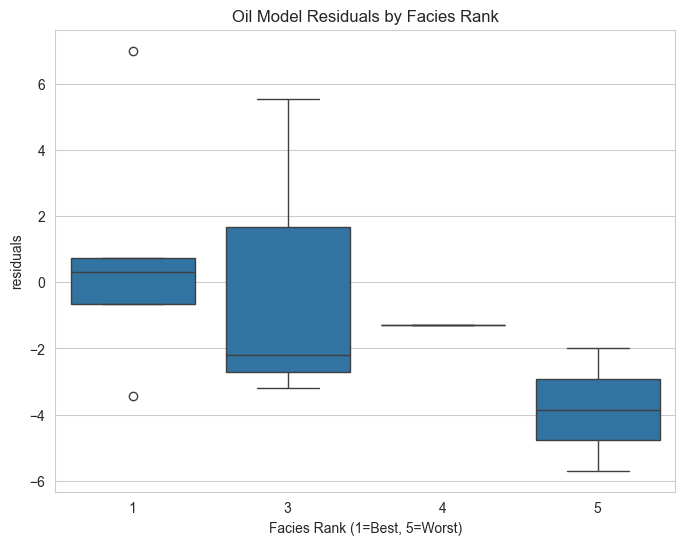

/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/867286596.py:47: RuntimeWarning: Mean of empty slice.
  bin_means_pred = [y_oil_pred[bin_indices==i].mean() for i in range(1, n_bins+1)]
/Users/paawandesai/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


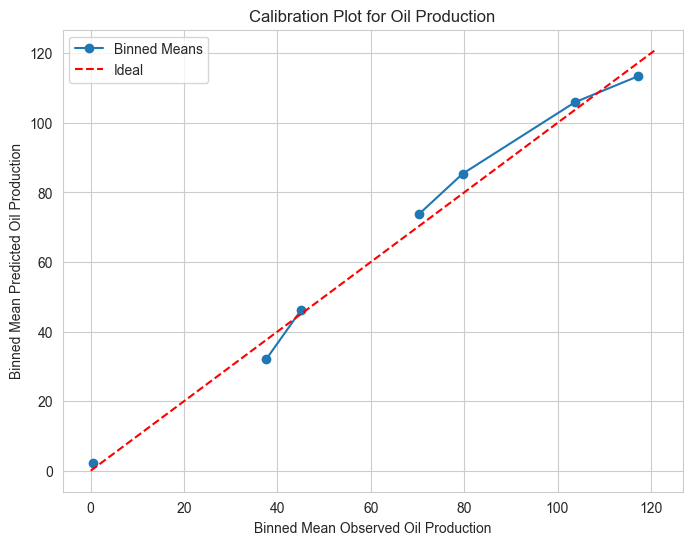

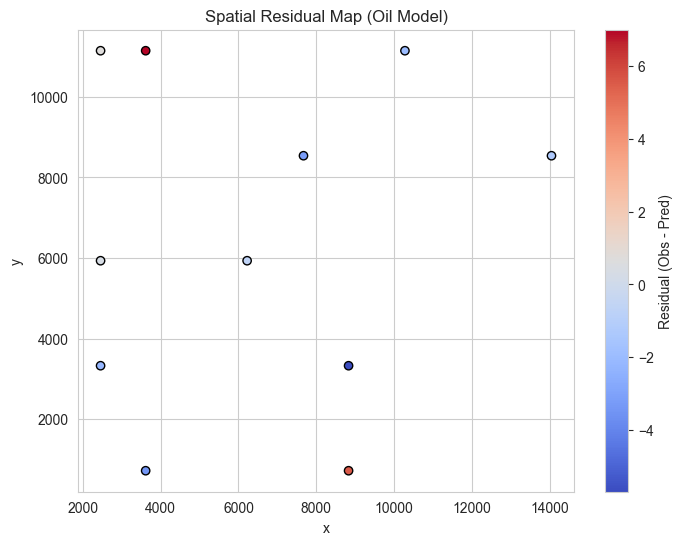

/Users/paawandesai/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/paawandesai/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/paawandesai/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/paawandesai/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/paawandesai/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/paawandesai/Library/Pyt

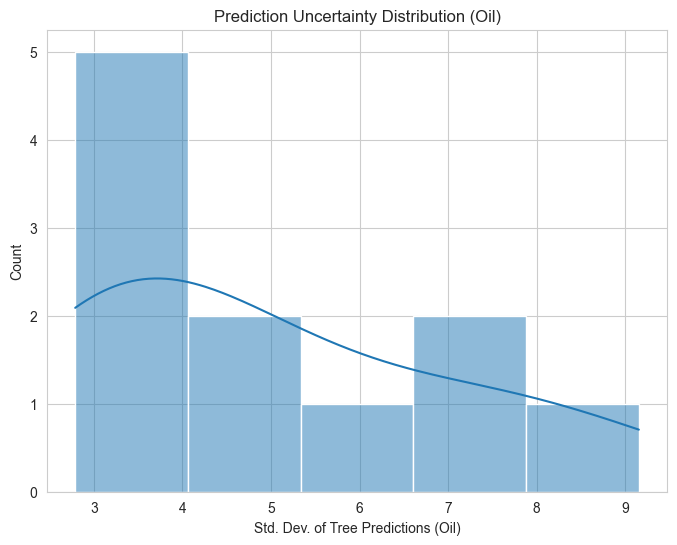

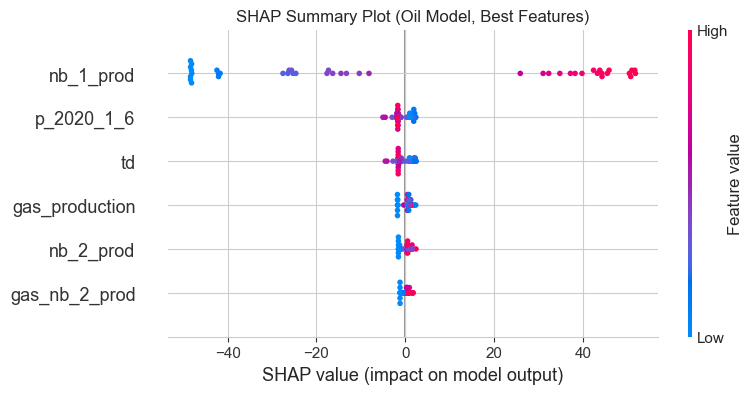

In [31]:
###########################################
# 3. Oil Production Pipeline with Recursive SHAP Ranking
###########################################
oil_exclude = ['well_number', 'well_name', 'oil_production', 'ogr']
X_oil = df.drop(columns=oil_exclude)
y_oil = df['oil_production']

print("\nOil model predictors:")
print(X_oil.columns.tolist())

imputer_oil = SimpleImputer(strategy='mean')
X_oil_imputed = pd.DataFrame(imputer_oil.fit_transform(X_oil), columns=X_oil.columns)

X_oil_train, X_oil_test, y_oil_train, y_oil_test = train_test_split(X_oil_imputed, y_oil, test_size=0.2, random_state=42)

rf_oil = RandomForestRegressor(n_estimators=250, random_state=42)
print("\nRecursive SHAP ranking for oil production:")
best_oil_features, oil_scores, oil_feature_sets = recursive_shap_feature_ranking(X_oil_train, y_oil_train, rf_oil, min_features=5)

rf_oil.fit(X_oil_train[best_oil_features], y_oil_train)
y_oil_pred = rf_oil.predict(X_oil_test[best_oil_features])

print("\nOil Model Evaluation:")
print("R2:", r2_score(y_oil_test, y_oil_pred))
print("MAE:", mean_absolute_error(y_oil_test, y_oil_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_oil_test, y_oil_pred)))

# Error Distribution by Facies Rank (only if facies_rank exists)
if 'facies_rank' in df.columns:
    X_oil_test_indices = X_oil_test.index
    facies_test = df.loc[X_oil_test_indices, 'facies_rank']
    oil_errors_df = pd.DataFrame({'facies_rank': facies_test, 'residuals': (y_oil_test - y_oil_pred).values})
    plt.figure()
    sns.boxplot(x='facies_rank', y='residuals', data=oil_errors_df)
    plt.xlabel("Facies Rank (1=Best, 5=Worst)")
    plt.title("Oil Model Residuals by Facies Rank")
    plt.show()
else:
    print("facies_rank column not found; skipping facies-based error distribution.")

    # Additional Oil Visualizations

# Calibration Plot
n_bins = 10
bins = np.linspace(y_oil_test.min(), y_oil_test.max(), n_bins+1)
bin_indices = np.digitize(y_oil_pred, bins)
bin_means_pred = [y_oil_pred[bin_indices==i].mean() for i in range(1, n_bins+1)]
bin_means_obs = [y_oil_test[bin_indices==i].mean() for i in range(1, n_bins+1)]
plt.figure()
plt.plot(bin_means_obs, bin_means_pred, 'o-', label='Binned Means')
plt.plot([y_oil_test.min(), y_oil_test.max()], [y_oil_test.min(), y_oil_test.max()], 'r--', label='Ideal')
plt.xlabel("Binned Mean Observed Oil Production")
plt.ylabel("Binned Mean Predicted Oil Production")
plt.title("Calibration Plot for Oil Production")
plt.legend()
plt.show()

# Partial Dependence Plot for 'porosity'
if 'porosity' in best_oil_features:
    fig, ax = plt.subplots()
    PartialDependenceDisplay.from_estimator(rf_oil, X_oil_train[best_oil_features], features=['porosity'], ax=ax)
    ax.set_title("Partial Dependence: Porosity")
    plt.show()

# Spatial Residual Map
residuals_oil = y_oil_test - y_oil_pred
X_oil_test_with_coords = X_oil_test.copy()
X_oil_test_with_coords['residuals'] = residuals_oil.values
plt.figure()
sc = plt.scatter(X_oil_test_with_coords['x'], X_oil_test_with_coords['y'], c=X_oil_test_with_coords['residuals'],
                 cmap='coolwarm', edgecolor='k')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spatial Residual Map (Oil Model)")
plt.colorbar(sc, label="Residual (Obs - Pred)")
plt.show()

# Uncertainty from tree predictions
tree_preds = np.array([tree.predict(X_oil_test[best_oil_features]) for tree in rf_oil.estimators_])
pred_std = tree_preds.std(axis=0)
plt.figure()
sns.histplot(pred_std, kde=True)
plt.xlabel("Std. Dev. of Tree Predictions (Oil)")
plt.title("Prediction Uncertainty Distribution (Oil)")
plt.show()

# SHAP Dependence Plot for 'porosity'
if 'porosity' in best_oil_features:
    shap.dependence_plot('porosity', shap_vals_oil, X_oil_train[best_oil_features])

# SHAP Summary Plot for Oil Model
explainer_oil = shap.TreeExplainer(rf_oil)
shap_vals_oil = explainer_oil.shap_values(X_oil_train[best_oil_features])
shap.summary_plot(shap_vals_oil, X_oil_train[best_oil_features], show=False)
plt.title("SHAP Summary Plot (Oil Model, Best Features)")
plt.show()


Gas model predictors:
['x', 'y', 'oil_production', 'water_production', 'porosity', 'kx', 'ky', 'td', 'p_2020_1_6', 'p_2029_1_1', 'rqi', 'pressure_drawdown', 'facies_1', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'facies_rank', 'gas_nb_1_prod', 'gas_nb_1_dist', 'gas_nb_2_prod', 'gas_nb_2_dist', 'gas_nb_3_prod', 'gas_nb_3_dist', 'gas_nb_4_prod', 'gas_nb_4_dist', 'gas_nb_5_prod', 'gas_nb_5_dist', 'gas_nb_6_prod', 'gas_nb_6_dist', 'gas_nb_7_prod', 'gas_nb_7_dist', 'gas_nb_8_prod', 'gas_nb_8_dist', 'gas_nb_9_prod', 'gas_nb_9_dist', 'gas_nb_10_prod', 'gas_nb_10_dist', 'gas_nb_11_prod', 'gas_nb_11_dist', 'gas_nb_12_prod', 'gas_nb_12_dist', 'gas_nb_13_prod', 'gas_nb_13_dist', 'gas_nb_14_prod', 'gas_nb_14_dist', 'gas_nb_15_prod', 'gas_nb_15_dist', 'gas_nb_16_prod', 'gas_nb_16_dist', 'gas_nb_17_prod', 'gas_nb_17_dist', 'gas_nb_18_prod', 'gas_nb_18_dist', 'gas_nb_19_prod', 'gas_nb_19_dist', 'gas_nb_20_prod', 'gas_nb_20_dist', 'gas_nb_21_prod', 'gas_nb_21_dist', 'gas_nb_22_prod', 'gas_nb_22_

/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/520201805.py:34: RuntimeWarning: Mean of empty slice.
  bin_means_pred_gas = [y_gas_pred[bin_indices_gas==i].mean() for i in range(1, n_bins+1)]
/Users/paawandesai/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


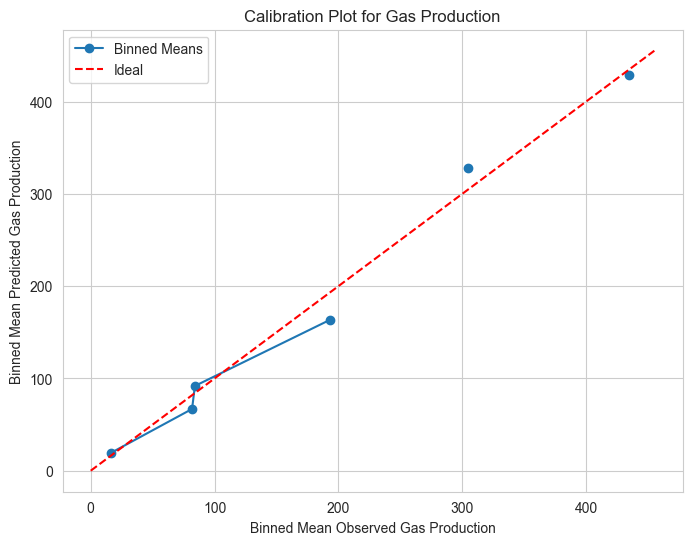

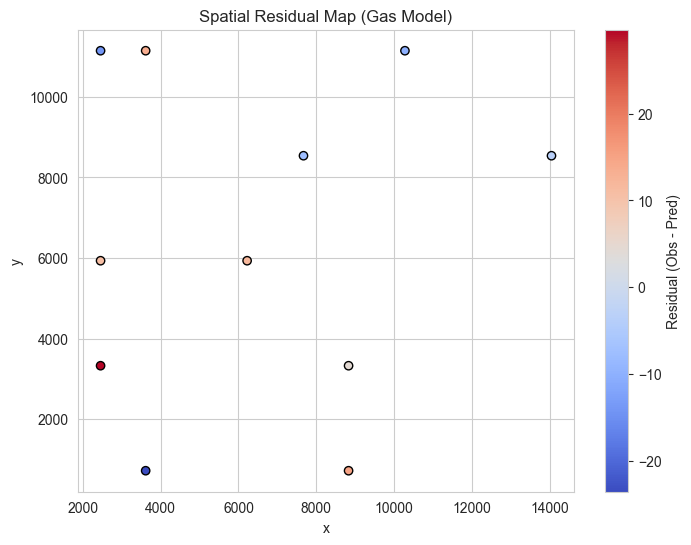

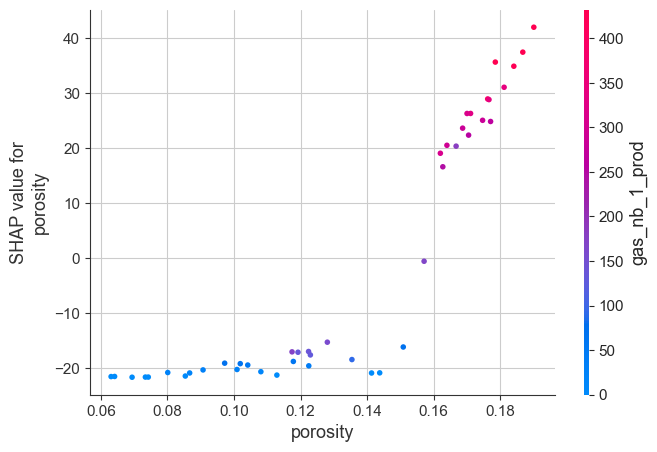

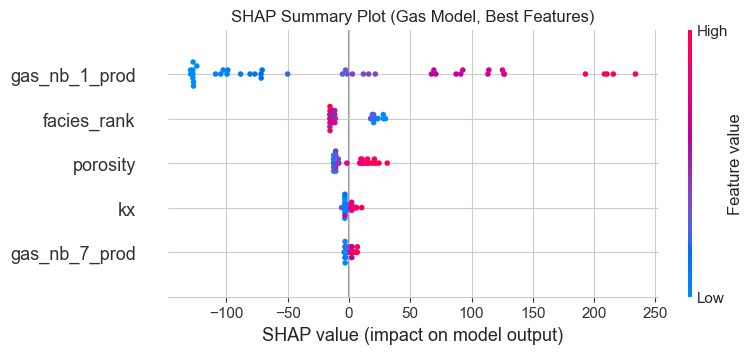

In [32]:
###########################################
# 4. Gas Production Pipeline with Recursive SHAP Ranking
###########################################
gas_exclude = ['well_number', 'well_name', 'gas_production', 'ogr']
oil_neighbor_cols = [col for col in df.columns if col.startswith('nb_')]
gas_exclude += oil_neighbor_cols
X_gas = df.drop(columns=gas_exclude)
y_gas = df['gas_production']

print("\nGas model predictors:")
print(X_gas.columns.tolist())

imputer_gas = SimpleImputer(strategy='mean')
X_gas_imputed = pd.DataFrame(imputer_gas.fit_transform(X_gas), columns=X_gas.columns)

X_gas_train, X_gas_test, y_gas_train, y_gas_test = train_test_split(X_gas_imputed, y_gas, test_size=0.2, random_state=42)

rf_gas = RandomForestRegressor(n_estimators=250, random_state=42)
print("\nRecursive SHAP ranking for gas production:")
best_gas_features, gas_scores, gas_feature_sets = recursive_shap_feature_ranking(X_gas_train, y_gas_train, rf_gas, min_features=5)
print("\nBest gas feature set:", best_gas_features)

rf_gas.fit(X_gas_train[best_gas_features], y_gas_train)
y_gas_pred = rf_gas.predict(X_gas_test[best_gas_features])

print("\nGas Model Evaluation:")
print("R2:", r2_score(y_gas_test, y_gas_pred))
print("MAE:", mean_absolute_error(y_gas_test, y_gas_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_gas_test, y_gas_pred)))

# Calibration Plot for Gas
bins = np.linspace(y_gas_test.min(), y_gas_test.max(), n_bins+1)
bin_indices_gas = np.digitize(y_gas_pred, bins)
bin_means_pred_gas = [y_gas_pred[bin_indices_gas==i].mean() for i in range(1, n_bins+1)]
bin_means_obs_gas = [y_gas_test[bin_indices_gas==i].mean() for i in range(1, n_bins+1)]
plt.figure()
plt.plot(bin_means_obs_gas, bin_means_pred_gas, 'o-', label='Binned Means')
plt.plot([y_gas_test.min(), y_gas_test.max()], [y_gas_test.min(), y_gas_test.max()], 'r--', label='Ideal')
plt.xlabel("Binned Mean Observed Gas Production")
plt.ylabel("Binned Mean Predicted Gas Production")
plt.title("Calibration Plot for Gas Production")
plt.legend()
plt.show()

# Spatial Residual Map for Gas
residuals_gas = y_gas_test - y_gas_pred
X_gas_test_with_coords = X_gas_test.copy()
plt.figure()
sc = plt.scatter(X_gas_test_with_coords['x'], X_gas_test_with_coords['y'], c=residuals_gas,
                 cmap='coolwarm', edgecolor='k')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spatial Residual Map (Gas Model)")
plt.colorbar(sc, label="Residual (Obs - Pred)")
plt.show()

# SHAP Dependence Plot for first best gas feature
if best_gas_features:
    shap.dependence_plot(best_gas_features[0], shap_vals_gas, X_gas_train[best_gas_features])

# SHAP Summary Plot for Gas Model
explainer_gas = shap.TreeExplainer(rf_gas)
shap_vals_gas = explainer_gas.shap_values(X_gas_train[best_gas_features])
shap.summary_plot(shap_vals_gas, X_gas_train[best_gas_features], show=False)
plt.title("SHAP Summary Plot (Gas Model, Best Features)")
plt.show()

/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/3647325244.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_df[f'nb_{i+1}_dist'] = dist_new[:, i]
/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/3647325244.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candidate_df[f'nb_{i+1}_prod'] = nb_prods_new[:, i]
/var/folders/n2/x27jkg3d76385q0d7qh998hm0000gn/T/ipykernel_88125/3647325244.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f


Candidate predictions saved to 'oil_rfsi_predictions_all_locations.csv' and 'gas_rfsi_predictions_all_locations.csv'.


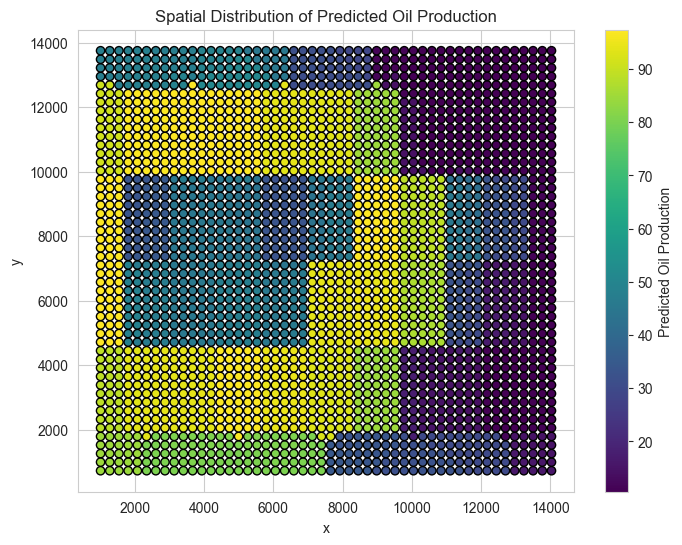

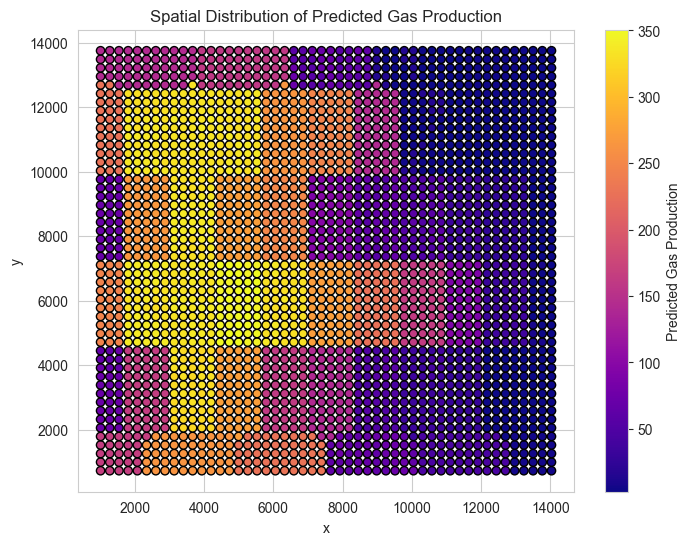

In [33]:
###########################################
# 5. Candidate Predictions for Oil and Gas
###########################################
x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()
num_points_x = 50
num_points_y = 50
x_vals = np.linspace(x_min, x_max, num_points_x)
y_vals = np.linspace(y_min, y_max, num_points_y)
grid_x, grid_y = np.meshgrid(x_vals, y_vals)
candidate_df = pd.DataFrame({'x': grid_x.ravel(), 'y': grid_y.ravel()})

# Oil candidate predictions
base_oil_cols = [col for col in X_oil_imputed.columns if not col.startswith('nb_')]
for col in base_oil_cols:
    if col not in ['x', 'y']:
        candidate_df[col] = X_oil_imputed[col].mean()
new_coords = candidate_df[['x','y']].values
dist_new, ind_new = nbrs_model.kneighbors(new_coords, n_neighbors=n_neighbors)
nb_prods_new = df['oil_production'].values[ind_new]
for i in range(n_neighbors):
    candidate_df[f'nb_{i+1}_prod'] = nb_prods_new[:, i]
    candidate_df[f'nb_{i+1}_dist'] = dist_new[:, i]
features_list_oil = X_oil_imputed.columns
candidate_df_oil = pd.DataFrame(imputer_oil.transform(candidate_df[features_list_oil]), columns=features_list_oil)
oil_candidate_preds = rf_oil.predict(candidate_df_oil[best_oil_features])
candidate_df['predicted_oil_production'] = oil_candidate_preds

# Gas candidate predictions
candidate_df_gas = candidate_df[['x','y']].copy()
base_gas_cols = [col for col in X_gas_imputed.columns if not col.startswith('gas_nb_')]
for col in base_gas_cols:
    if col not in ['x', 'y']:
        candidate_df_gas[col] = X_gas_imputed[col].mean()
dist_new_gas, ind_new_gas = nbrs_model.kneighbors(new_coords, n_neighbors=n_neighbors)
gas_nb_prods_new = df['gas_production'].values[ind_new_gas]
for i in range(n_neighbors):
    candidate_df_gas[f'gas_nb_{i+1}_prod'] = gas_nb_prods_new[:, i]
    candidate_df_gas[f'gas_nb_{i+1}_dist'] = dist_new_gas[:, i]
features_list_gas = X_gas_imputed.columns
candidate_df_gas_imputed = pd.DataFrame(imputer_gas.transform(candidate_df_gas[features_list_gas]), columns=features_list_gas)
gas_candidate_preds = rf_gas.predict(candidate_df_gas_imputed[best_gas_features])
candidate_df_gas['predicted_gas_production'] = gas_candidate_preds

candidate_df.to_csv('oil_rfsi_predictions_all_locations.csv', index=False)
candidate_df_gas.to_csv('gas_rfsi_predictions_all_locations.csv', index=False)
print("\nCandidate predictions saved to 'oil_rfsi_predictions_all_locations.csv' and 'gas_rfsi_predictions_all_locations.csv'.")

# Visualization of candidate predictions
plt.figure()
sc = plt.scatter(candidate_df['x'], candidate_df['y'], c=candidate_df['predicted_oil_production'],
                 cmap='viridis', edgecolor='k')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spatial Distribution of Predicted Oil Production")
plt.colorbar(sc, label="Predicted Oil Production")
plt.show()

plt.figure()
sc = plt.scatter(candidate_df_gas['x'], candidate_df_gas['y'], c=candidate_df_gas['predicted_gas_production'],
                 cmap='plasma', edgecolor='k')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spatial Distribution of Predicted Gas Production")
plt.colorbar(sc, label="Predicted Gas Production")
plt.show()